# BPMN Process Generation

We generated 10 BPMN processes for each combination of maximum nested XOR and maximum independent XOR, ranging from 1 to 10. This resulted in a total of 1000 unique processes (10 x 10 x 10). The generation process follows these general steps:

1. Start with a seed string '_', which represents a single task.

2. Iteratively replace underscores with one of three possible structures:
   - XOR split: `(_ ^ _)`
   - Parallel split: `(_ || _)`
   - Sequential: `(_ , _)`

3. The replacement process continues until the desired complexity (in terms of nested and independent XORs) is achieved.

4. Finally, replace remaining underscores with task labels (T1, T2, etc.).

The generation process uses weighted random choices to determine which structure to use for each replacement. This allows for controlled variability in the generated processes.

Key aspects of the generation:

- The `replace_random_underscore` function (in `random_diagram_generation.py`) performs the core replacement logic.
- Probabilities for each type of replacement can be specified or randomly generated using `guess_three_numbers` (in `random_diagram_generation.py`).
- The `max_nested_xor` and `max_independent_xor` functions (in `stats.py`) are used to evaluate the complexity of the generated processes.
- The `generate_multiple_processes` function (in `random_batch_generation.py`) manages the overall generation process, ensuring the desired number of processes with specific complexities are created.

This approach ensures a diverse set of BPMN processes with varying levels of complexity, suitable for thorough testing and analysis of process-related algorithms.

Using probabilities: (0.7859844514685936, 0.1346035822392726, 0.07941196629213376)
Generated Process:
(((T1 ^ ((T2 ^ (T3 ^ T4)) ^ (T5 ^ T6))) ^ (T7 ^ (T8 ^ (T9 || T10)))) ^ T11)

Max Nested XOR: 6
Max Independent XOR: 1

Process Diagram:


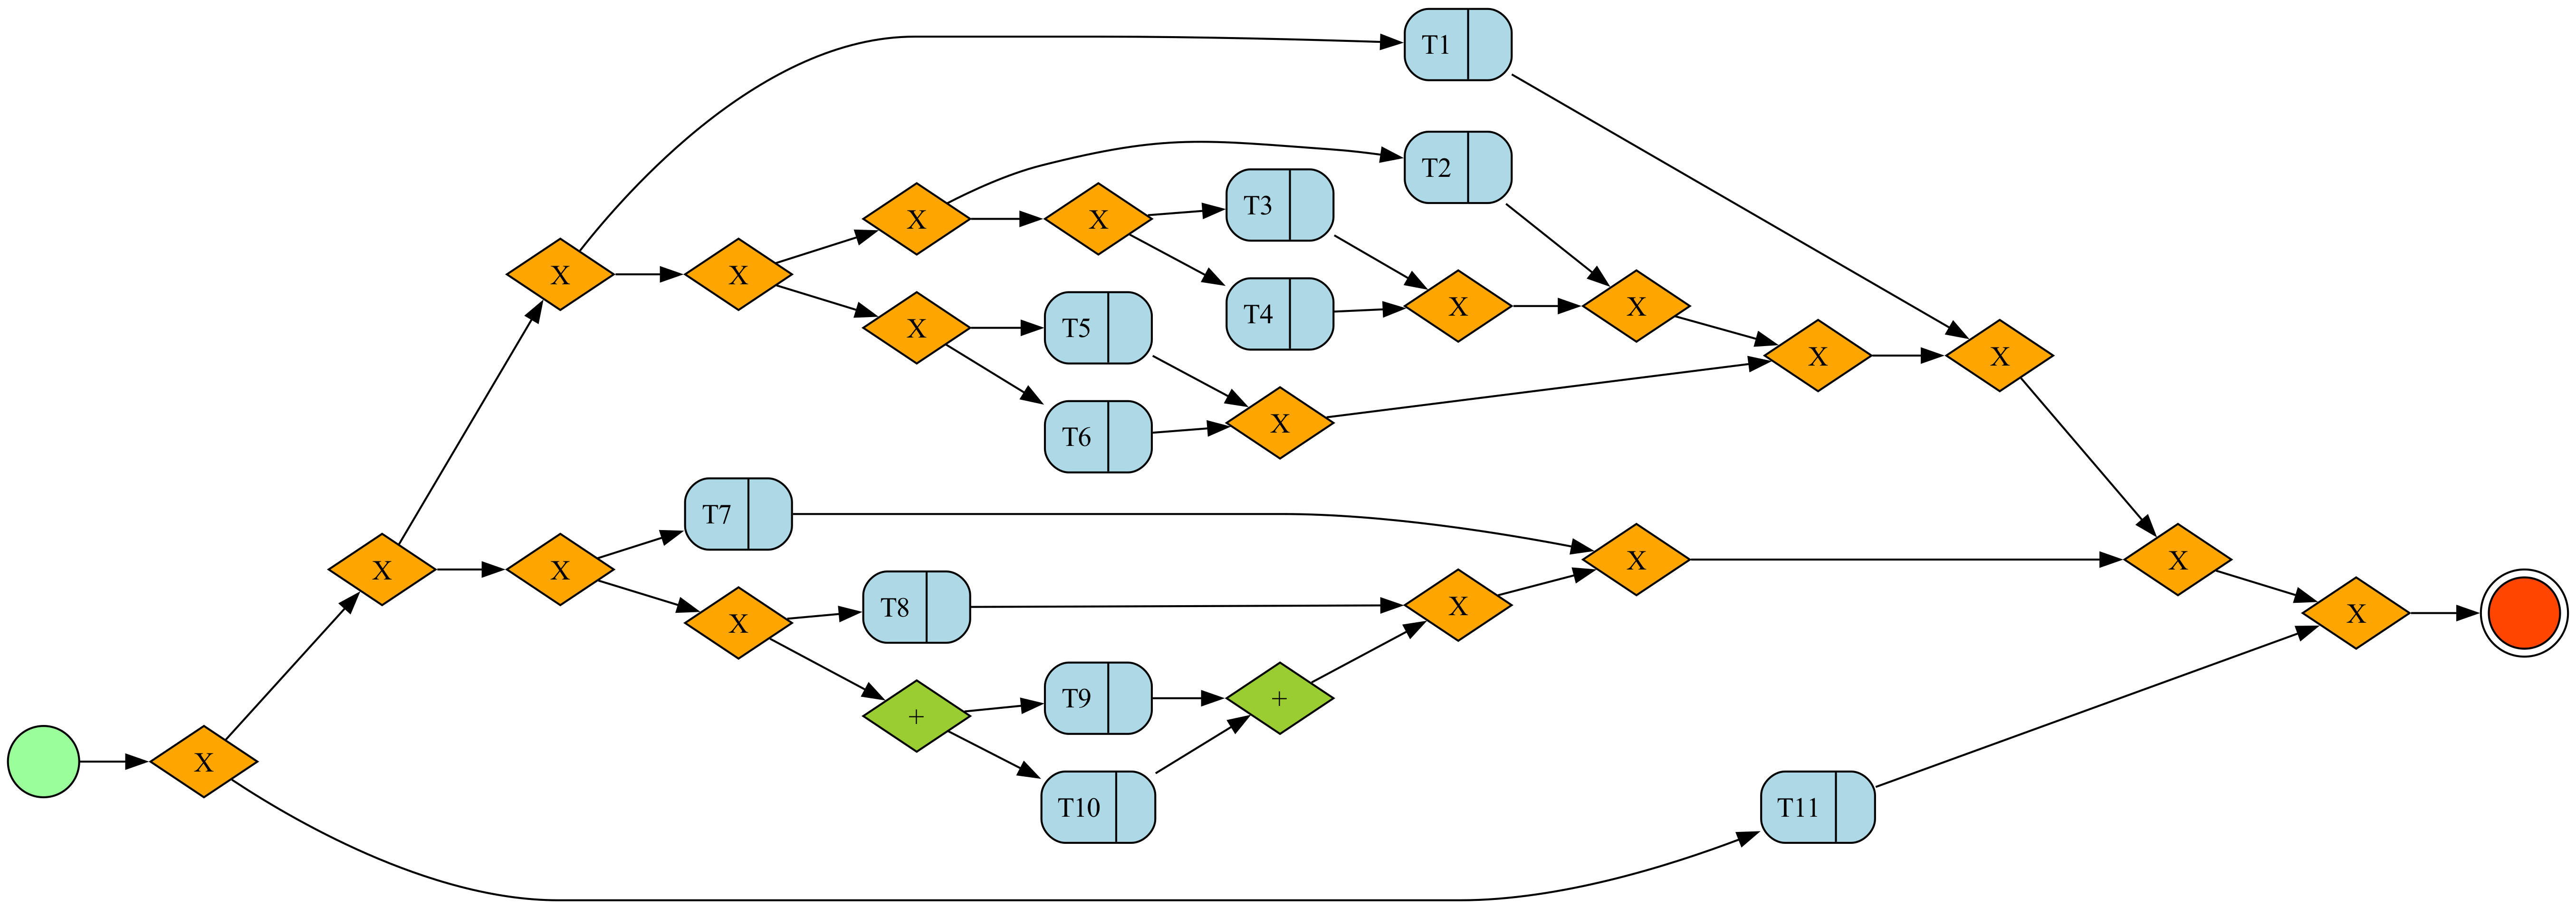

In [1]:
# Import necessary functions and modules
from random_diagram_generation import SEED_STRING, replace_random_underscore, replace_underscores, guess_three_numbers
from sese_diagram import PARSER, print_sese_diagram, print_tree, dot_tree
from stats import max_nested_xor, max_independent_xor

# Generate a process
current_string = SEED_STRING
probabilities = guess_three_numbers()
print(f"Using probabilities: {probabilities}")

iterations = 10
for _ in range(iterations):
    current_string = replace_random_underscore(current_string, probabilities)

process = replace_underscores(current_string)
print("Generated Process:")
print(process)

# Parse the process
tree = PARSER.parse(process)

# Print process statistics
print(f"\nMax Nested XOR: {max_nested_xor(process)}")
print(f"Max Independent XOR: {max_independent_xor(process)}")

# Visualize the process
print("\nProcess Diagram:")
print_sese_diagram(process)



Process Tree:


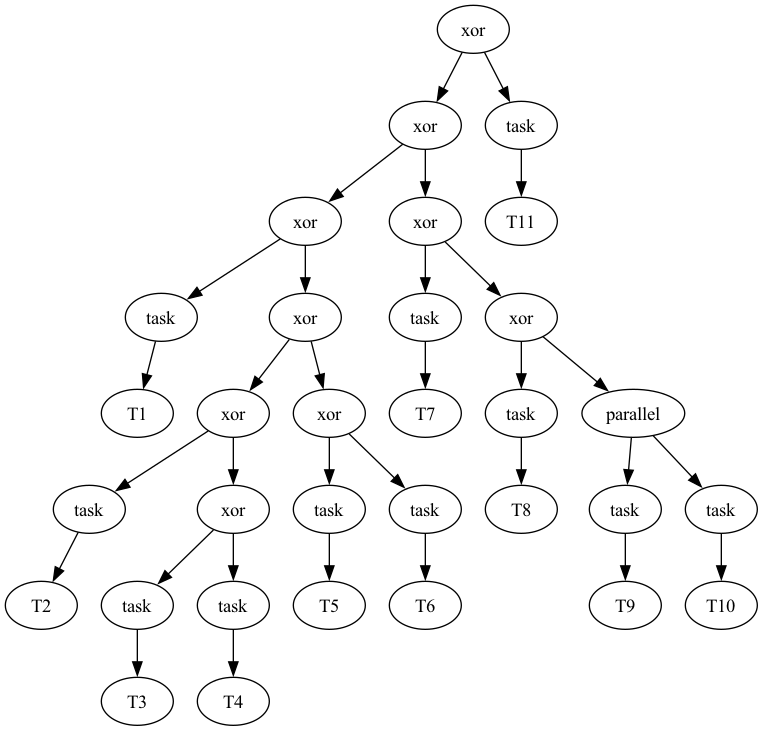

In [2]:

# Print the parse tree
print("\nProcess Tree:")
print_tree(dot_tree(tree)[0])

# Impact Vector Generation

After generating the BPMN processes, we create a set of impact vectors for each process. These impact vectors represent the multi-dimensional effects or outcomes of the tasks within each process. We use six different modes to generate these vectors, each providing a unique distribution of values. The impact vectors are generated using functions from `generate_impacts.py`.

## Generation Modes

1. **Random**: 
   - Generates vectors where each dimension is a random value between 0 and 1.
   - No further modifications are made to these vectors.

2. **Bagging Divide**: 
   - Starts with random vectors (values between 0 and 1).
   - Randomly selects dimensions and divides their values by 10.
   - This creates vectors with a mix of larger (original) and smaller (divided) impacts.

3. **Bagging Remove**: 
   - Starts with random vectors (values between 0 and 1).
   - Randomly selects dimensions and sets their values to 0.
   - The result is a sparse vector where some dimensions have no impact.

4. **Bagging Remove Divide**: 
   - Starts with random vectors (values between 0 and 1).
   - Randomly selects dimensions and sets their values to 0.
   - For the non-zero dimensions, randomly selects some and divides their values by 10.
   - This creates sparse vectors with a mix of original and reduced non-zero values.

5. **Bagging Remove Reverse**: 
   - Starts with random vectors (values between 0 and 1).
   - Creates a new vector of zeros with the same dimension.
   - Randomly selects dimensions from the original vector and copies their values to the new vector.
   - This results in a sparse vector where the non-zero values retain their original magnitudes and positions.

6. **Bagging Remove Reverse Divide**: 
   - Starts with random vectors (values between 0 and 1).
   - Creates a new vector of zeros with the same dimension.
   - Randomly selects dimensions from the original vector and copies their values to the new vector.
   - Among the non-zero values in the new vector, randomly selects some and divides them by 10.
   - This creates a sparse vector with a mix of original and reduced non-zero values in their original positions.

## Process

For each BPMN process:
1. We determine the number of tasks in the process.
2. We generate a set of impact vectors equal to the number of tasks, using one of the six modes described above.
3. The dimension of each vector corresponds to the number of impact factors being considered (ranging from 1 to 10 in our experiments).
4. These vectors are then associated with the tasks in the process in order of appearance.

For example, if a process has 5 tasks, we generate 5 impact vectors using the chosen mode. Then we assign these vectors to the tasks in the order they appear in the process description.

## Dimension Range

In our experiments, we generate impact vectors with dimensions varying from 1 to 10. This range allows us to analyze how the number of impact factors affects the complexity and performance of our algorithms.

## Association with Tasks

The association of impact vectors with tasks is done by creating a dictionary where:
- The keys are the task identifiers (e.g., "T1", "T2", "T3", etc.)
- The values are the corresponding generated impact vectors

This dictionary is then used in subsequent analyses to retrieve the impact vector for any given task in the process.

By using these diverse generation modes, varying dimensions, and associating vectors with specific tasks, we create a comprehensive dataset that captures a wide range of possible impact distributions across different process structures. This approach enables thorough testing and analysis of our process impact evaluation algorithms across different scenarios and complexities.


Process Diagram with Impact Vectors (truncated to 2 decimal places):


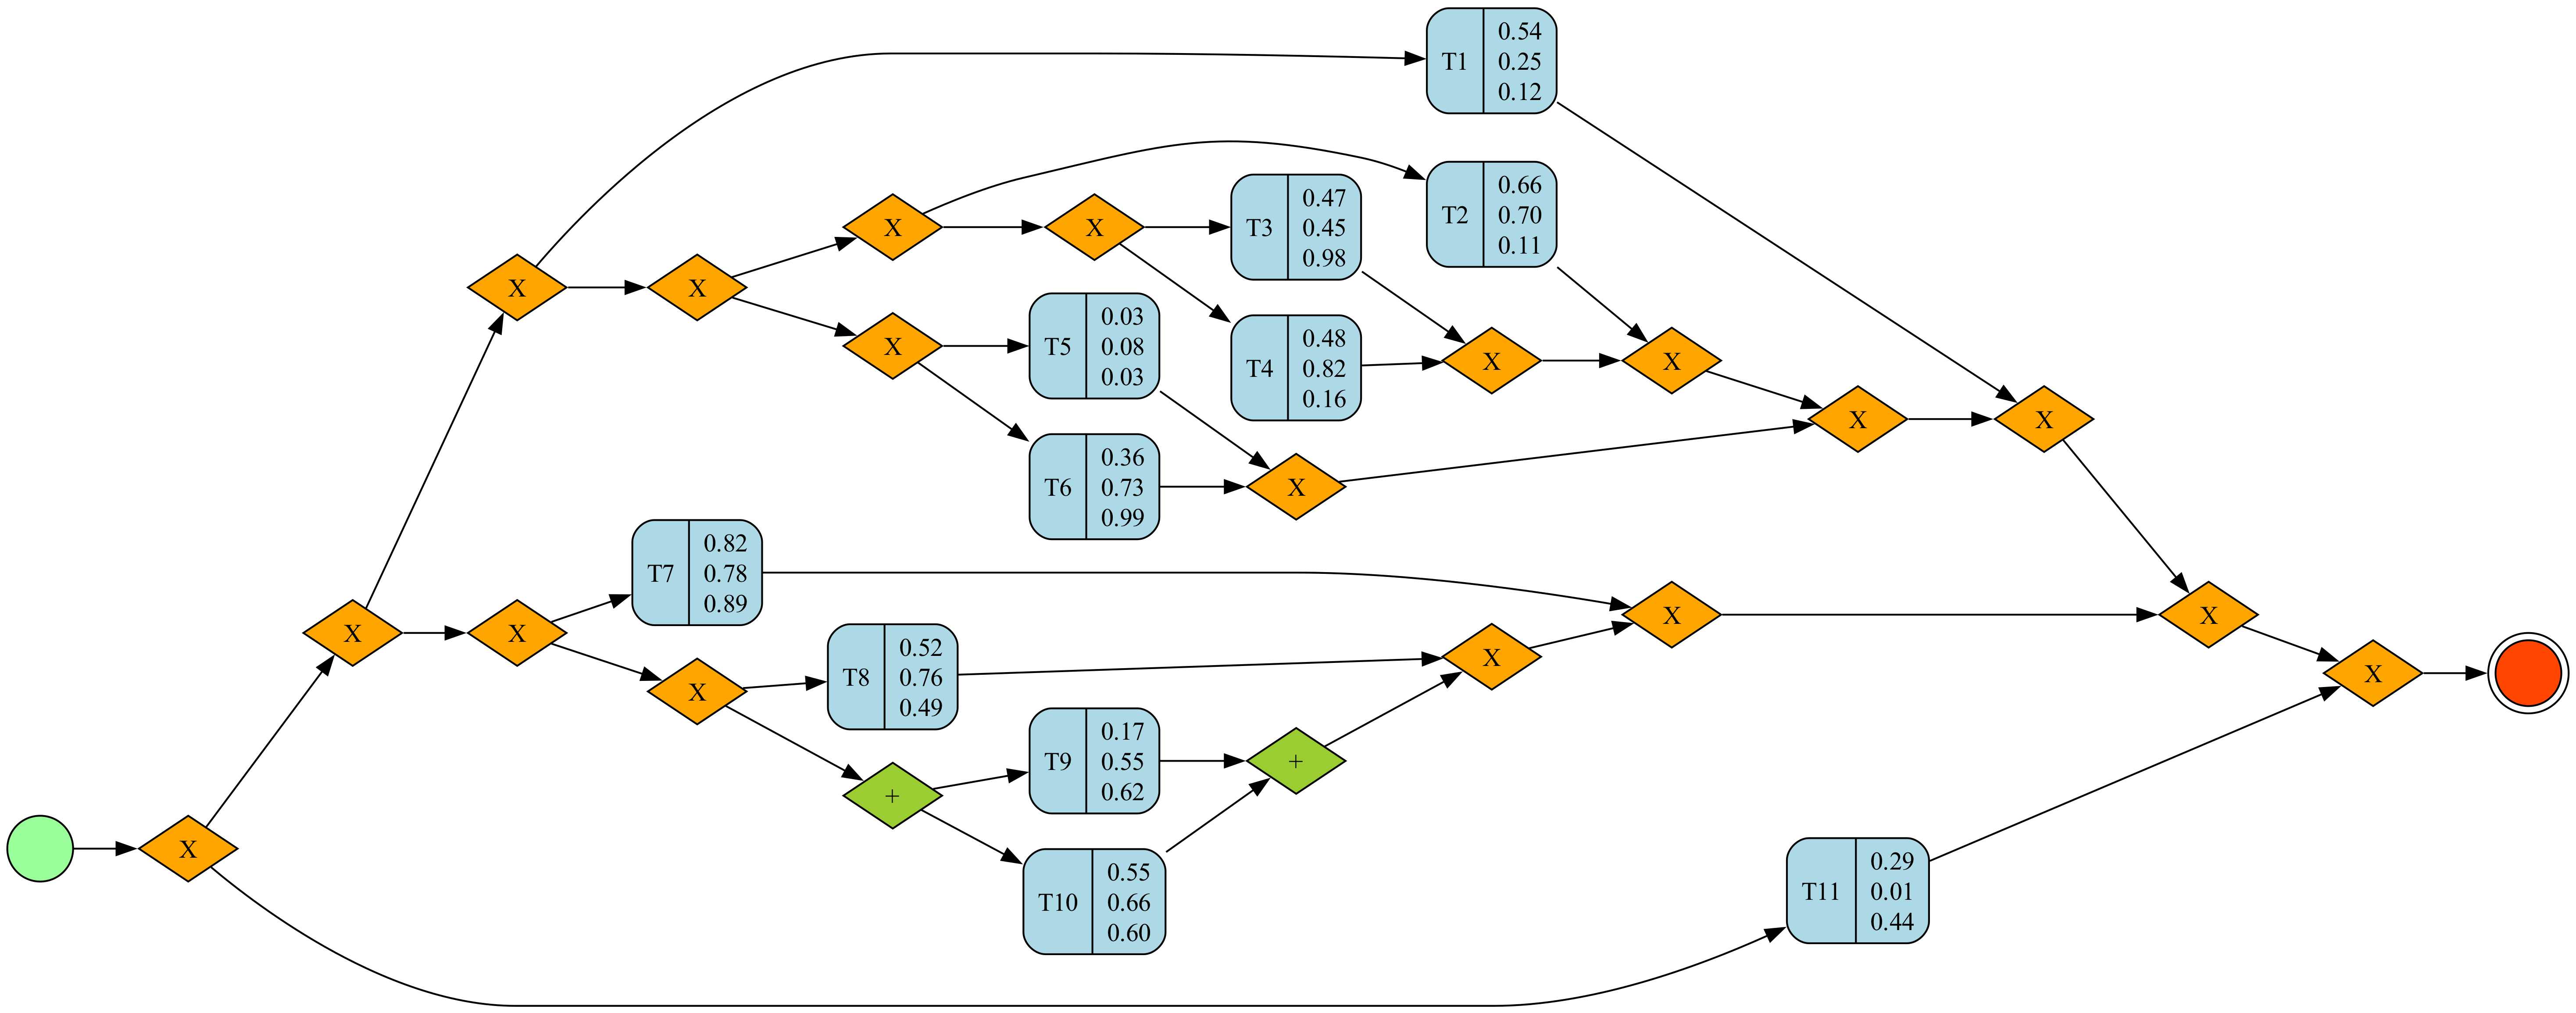

In [3]:
from generate_impacts import generate_vectors
from utils import find_max_task_number


num_tasks = find_max_task_number(process)
dimension = 3 

vectors = generate_vectors(num_tasks, dimension, mode="random")  # You can change the mode as needed

impacts = {f"T{i+1}": vector.tolist() for i, vector in enumerate(vectors)}

print("\nProcess Diagram with Impact Vectors (truncated to 2 decimal places):")
print_sese_diagram(process, impacts=impacts, impacts_names=[f"Impact {i+1}" for i in range(dimension)])

# Vector Generation and Analysis Process

To analyze the characteristics of our impact vector generation methods, we will conduct a comprehensive study across different dimensions and generation modes. This process will help us understand how the different generation modes affect the distribution and relationships between the vectors.

## Process Overview

1. **Vector Generation**: 
   - For each dimension (1 to 10) and each of the six generation modes, we will generate 100 vectors.
   - This results in 60 sets of 100 vectors each (10 dimensions × 6 modes).

2. **Cosine Distance Calculation**:
   - For each set of 100 vectors, we will compute the cosine distance between each pair of vectors.
   - The cosine distance is calculated as:

     $\text{cosine\_distance}(A, B) = 1 - \frac{A \cdot B}{\|A\| \|B\|}$

   where $A \cdot B$ is the dot product of vectors A and B, and $\|A\|$ and $\|B\|$ are the magnitudes of vectors A and B respectively.

   - **Important Note**: Since all our generated vectors contain only non-negative values, the cosine distance will always be between 0 and 1. This is because:
     - The dot product of two non-negative vectors is always non-negative.
     - The magnitudes of non-negative vectors are always positive.
     - Therefore, the fraction $\frac{A \cdot B}{\|A\| \|B\|}$ is always between 0 and 1.
     - Subtracting this fraction from 1 gives us a distance that is also between 0 and 1.

3. **Statistical Analysis**:
   - For each set of cosine distances (4950 distances per set, as there are $\binom{100}{2} = 4950$ pairs in 100 vectors), we will compute:
     - The mean cosine distance
     - The standard deviation of the cosine distances

4. **Visualization**:
   - We will create a scatter plot to visualize the results:
     - X-axis: Dimensions (1 to 10)
     - Y-axis: Mean cosine distance
     - Error bars: Representing the standard deviation, clamped to the [0, 1] range
     - Different colors and symbols for each generation mode

## Generation Modes

We will use the following six modes for vector generation, in this order:

1. Random
2. Bagging Divide
3. Bagging Remove
4. Bagging Remove Divide
5. Bagging Remove Reverse
6. Bagging Remove Reverse Divide

## Expected Insights

This analysis will allow us to:
- Understand how the different generation modes affect the similarity/dissimilarity between vectors.
- Observe how the dimensionality of the vectors impacts the distances between them.
- Identify which generation modes produce more diverse or more similar sets of vectors.
- Determine how the variability in distances changes across dimensions and generation modes.

These insights will be crucial for selecting appropriate vector generation methods for different scenarios in our BPMN process impact analysis. The bounded nature of our cosine distances, between 0 and 1 since we allow positive vectors, provides a consistent scale for comparing the different modes and dimensions.

In [4]:
%run impact_stats.py

# Run the analysis and plot the results
results, modes = generate_and_analyze_vectors(num_vectors=100, max_dim=10)
plot_mean_std_intervals_by_dimension(results, modes)

Analyzing modes: 100%|██████████| 6/6 [00:00<00:00,  7.76it/s]


## 👁️ Observation on Distances among Distinct Generation Strategies 👁️

Our objective is to generate sets of arrays whose elements are generally very distant from each other, and observe whether such dissimilarity influences the computational time, i.e., the size of the maximum Pareto frontier encountered during the execution of the algorithm. We hypothesize that the more "spread apart" the initial impact vectors associated with the tasks are (with respect to cosine distance), the longer the algorithm will take to compute the final Pareto frontier.

Let us evaluate the above results in terms of the proposed 6 generation strategies:

- The ```random``` modality generates sets of very similar arrays.
- ```bagging_divide``` creates generally less similar sets compared to ```bagging_remove``` and ```bagging_remove_divide```. Quite surprisingly, this trend is maintained even as we increase the dimension, indicating that when the impact arrays are not sparse, it is better to divide randomly than to set a few components to $0$. Surprisingly, dividing and setting a few components to $0$ worsens the spread.
- ```bagging_remove``` and ```bagging_remove_divide```, for the aforementioned reasons, have more spread than random but they still produce still fairly similar impact vectors.
- ```bagging_remove_reverse``` becomes slightly better than ```bagging_divide``` in terms of spreading as the dimension increases to 4 or more. Note that such arrays are sparse but maintain the same scale for the components since components are not randomly selected for division by $10$. It represents a slightly more difficult case than ```bagging_divide``` when dimension grows, despite the fact that components are not scaled.
- ```bagging_remove_reverse_divide``` generates significantly more spread-out sets of vectors as the dimension grows beyond 7. It represents the most appropriate strategy among the 6 proposed for generating worst-case scenarios.

As a final qualitative observation, we would like to point out that ```bagging_remove_reverse_divide``` represents many realistic scenarios where a single task impacts a small percentage of the total number of components, and the way different tasks affect the same component may be on different scales.

# Experimental Setup

We conducted a comprehensive experiment to analyze the impact of various factors on process complexity and performance. The experiment was implemented as described in `script.py` and covers a wide range of parameters:

## Parameters

1. **Dimensions (dim)**: 1 to 10
   - This represents the number of dimensions in the impact vectors associated with each task.

2. **Maximum Nested XOR (nested)**: 1 to 10
   - This parameter indicates the maximum depth of nested XOR gateways in the generated BPMN processes.

3. **Maximum Independent XOR (independent)**: 1 to 10
   - This represents the maximum number of independent XOR gateways at the same level in the generated BPMN processes.

4. **Process Number**: 1 to 10
   - For each combination of nested and independent XOR, we generated 10 different processes.

5. **Vector Generation Modes**:
   - random
   - bagging_divide
   - bagging_remove
   - bagging_remove_divide
   - bagging_remove_reverse
   - bagging_remove_reverse_divide

## Experiment Structure

For each combination of the above parameters, we performed the following steps:

1. Generated a BPMN process based on the nested and independent XOR parameters.
2. Created impact vectors for each task in the process using the specified dimension and generation mode.
3. Computed the maximum values and Pareto frontier for the process.
4. Measured the computation time for both the max values and Pareto frontier calculations.

In total, this experiment covers:
- 10 (dimensions) × 10 (nested XOR) × 10 (independent XOR) × 10 (process numbers) × 6 (generation modes) = 60,000 unique configurations

## Pareto Frontier and Domination Definition

An important concept in our analysis is the Pareto frontier, specifically the bottom Pareto frontier. Given a set of vectors, we define domination and the bottom Pareto frontier as follows:

### Domination

A vector $u$ is said to be dominated by another vector $v$ if:

1. For all dimensions, the value in $u$ is less than or equal to the corresponding value in $v$, AND
2. For at least one dimension, the value in $u$ is strictly less than the corresponding value in $v$.

Mathematically, for n-dimensional vectors $u$ and $v$, $u$ is dominated by $v$ if and only if:

$\forall i \in \{1, ..., n\} : u[i] \leq v[i] \land \exists j \in \{1, ..., n\} : u[j] < v[j]$

### Bottom Pareto Frontier

The bottom Pareto frontier (also known as the minimal Pareto set or minimal Pareto front) is the set of vectors that do not dominate any other vector in the set. 

Mathematically, for a set of n-dimensional vectors $V$, the bottom Pareto frontier $P$ is defined as:

$P = \{v \in V \mid \neg\exists u \in V : u \text{ is dominated by } v\}$

In other words, the bottom Pareto frontier consists of all vectors in $V$ that do not dominate any other vector in $V$.

In the context of our BPMN process analysis:
- Each vector represents the cumulative impact of a particular execution path through the process.
- The dimensions of the vectors correspond to different impact factors (e.g., time, cost, quality).
- We consider lower values as more desirable for our impact factors.
- The bottom Pareto frontier represents the set of execution paths that do not dominate any other paths, each of which is optimal in the sense that there's no other path that's better in all impact factors.

## Significance in Our Experiment

In our experiment:
- We generate impact vectors for each task, where lower values represent better outcomes.
- When we compute the Pareto frontier for a process, we're identifying the set of execution paths that are Pareto-optimal (i.e., do not dominate any other path).
- By using this domination definition, we identify the bottom Pareto frontier, which represents the best execution paths in terms of minimizing impact factors.
- The maximum length of the Pareto frontier gives us an indication of the complexity of trade-offs in the process – a longer frontier suggests more diverse, incomparable optimal solutions.

This approach allows us to analyze how different process structures and impact vector characteristics affect the set of optimal execution paths and the complexity of decision-making in process execution.

By focusing on vectors that do not dominate any others, we identify execution paths that offer unique trade-offs in minimizing impact factors, providing valuable insights into process optimization.

## Data Collection

For each run, we collected the following data and stored it in columns in our results.csv file:

- Nested XOR level (column: ```nested```)
- Independent XOR level (column: ```independent```)
- Process number (column: ```process_number```)
- Number of dimensions (column: ```dimensions```)
- Vector generation mode (column: ```mode```)
- Maximum length of the Pareto frontier (column: ```max_pareto```)
- Maximum theoretical length of the Pareto frontier (column: ```max_theoretical_pareto```)
- Computation time for max values (column: ```max_time```)
- Computation time for Pareto frontier (column: ```pareto_time```)

This data enables us to perform detailed analyses on the relationships between process structure, impact vector characteristics, and algorithmic performance.

## 💻 Computational Environment 🖥️

The computational times reported in this experiment were measured on a system with the following specifications:

- **Operating System**: Ubuntu 22.04.3 LTS
- **Processor**: Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz
- **Memory**: 32GB RAM

## ⚠️ Very Important Notes ⚠️

The following points are crucial for understanding the relationship between our experimental data and the problems addressed in the associated paper:

1. **Column "max_time"**: This represents the computation time for determining the maximal values for each component. It corresponds to checking if all paths respect a given bound, which is **Problem 2** as described in the paper.

2. **Problems 1 and 3 for single dimension**: Problem 1 with $k = 1$ and Problem 3 from the paper are equivalent to computing the Pareto frontier when the number of dimensions (dim) is 1.

3. **Pareto frontier as an upper bound**: For Problem 1 with $k > 1$ and Problem 3, the computation of the Pareto frontier serves as an upper bound for the computational time. This is because:
   - The Pareto frontier computation does not utilize the input_bound, which could potentially lead to a speed-up in the algorithm for these specific problems.
   - We chose to compute the full Pareto frontier instead of directly solving Problem 1 with $k > 1$ and Problem 3 to avoid introducing and managing an additional parameter (input_bound) in our experimental setup.
   - The computational time for the Pareto frontier (column: "pareto_time") thus provides a conservative estimate for the time required to solve these problems.

These notes are essential for correctly interpreting the results and understanding the scope of our analysis in relation to the theoretical problems discussed in the paper.

In [5]:

import pandas as pd
df = pd.read_csv("results.csv")
df

,nested,independent,process_number,dimensions,mode,max_pareto,max_theoretical_pareto,max_time,pareto_time
0,1,1,1,1,random,1,2,0.000036,0.000106
1,1,1,1,1,bagging_divide,1,2,0.000022,0.000072
2,1,1,1,1,bagging_remove,1,2,0.000062,0.000255
3,1,1,1,1,bagging_remove_divide,1,2,0.000058,0.000208
4,1,1,1,1,bagging_remove_reverse,1,2,0.000044,0.000135
...,...,...,...,...,...,...,...,...,...
47992,8,10,10,10,random,291,344736,0.000268,2.141025
47993,8,10,10,10,bagging_divide,3689,344736,0.000229,270.786698
47994,8,10,10,10,bagging_remove,1625,344736,0.000232,64.249752
47995,8,10,10,10,bagging_remove_divide,2132,344736,0.000232,83.422562


## ❌ Missing Experiments ❌ 

The following function prints the ```nested, independent, process_number, dimensions,mode```  assignments for which
we do not have experimental data due to excessive computational time.

In [6]:
%run computation_stats.py

missing_values(df, 8,10,10,10)

 88%|████████▊ | 7/8 [00:57<00:08,  8.15s/it]

Missing values for nested=8, independent=10, process_number=5, dimensions=9, mode=bagging_remove_reverse_divide
Missing values for nested=8, independent=10, process_number=5, dimensions=10, mode=bagging_remove_reverse_divide


100%|██████████| 8/8 [01:05<00:00,  8.16s/it]

Missing values for nested=8, independent=10, process_number=10, dimensions=10, mode=bagging_remove_reverse_divide


In [7]:
%run computation_stats.py

independent_name = "independent"
nested_name = "nested"

colorbar = dict(
                colorbar_x_left=0.45,
                colorbar_y_left=-0.3,
                colorbar_x_right=0.99,
                colorbar_y_right=-0.4
                )

create_log_heatmaps(df, independent_name, nested_name, "pareto_time", "Pareto Time", width=1200, **colorbar)

create_log_heatmaps(df, independent_name, nested_name, "max_pareto", "Max Pareto Region", width=1200, **colorbar)

create_log_heatmaps(df, independent_name, nested_name, "max_theoretical_pareto", "Max Theoretical Pareto Region Size", width=1200, **colorbar)

create_log_heatmaps(df, independent_name, nested_name, "max_time", "Max Component Time", width=1200, **colorbar, log=False)


## 👁️ Observation on Heatmaps for Experiment Metrics 👁️

In the above analysis, we provide heatmaps for the experiment metrics ```pareto_time```, ```max_pareto```, ```max_theoretical_pareto```, and ```max_time```, respectively. The heat is represented on a logarithmic scale due to the exponential nature of the problem, except for the heatmaps of ```max_time```, since this problem is polynomial.

Processes are grouped in each cell of the heatmap according to their ```independent``` and ```nested``` parameters, which represent the maximum number of independent XORs and the maximum number of nested XORs, respectively. For each metric, we present two heatmaps: one showing the average of the metric, and its twin showing the standard deviation.

From this analysis, we can make two main observations:

1. Both the average and standard deviation are affected more significantly when we increase ```independent``` and ```nested``` together, rather than increasing just one of the two parameters.

2. The growing standard deviation is likely due to the fact that generation strategies and dimensions are not accounted for in this initial analysis. That is, all processes with the same combination of ```independent``` and ```nested``` are placed in the same bucket, regardless of their generation strategy or dimension.